This is the fourth tutorial and explains the basic usage of DoG-HiT by recovering the ring synthetic image from ngEHT coverage. This tutorial is meant to present some of the fundamental ideas behind DoG-HiT. Note that the complete analysis pipeline with the best reconstruction results will be shown in tutorial 6.

The minimization by wavelets with DoG-HiT is handled by the MinimizationHandler class. Let us load all the needed modules.

In [1]:
#-------------------------------------------------------------------------------
# Modules
#-------------------------------------------------------------------------------
import ehtim as eh
import numpy as np

import logging

from imagingbase.minimization_handler import MinimizationHandler

import ehtplot.color
cfun = 'afmhot_u'

import pathlib 
current_path = str(pathlib.Path().absolute())

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s %(levelname)s %(name)-20s :: %(message)s'
)

Welcome to eht-imaging! v 1.2.4 



Fixed imaging parameters

In [2]:
#-------------------------------------------------------------------------------
# Fixed imaging parameters
#-------------------------------------------------------------------------------
ttype     = 'direct'            # Type of Fourier transform ('direct', 'nfft', or 'fast')

zbl       = 0.6                 # Total compact flux density (Jy)
npix      = 64                 # Number of pixels across the reconstructed image
fov       = 256*eh.RADPERUAS    # Field of view of the reconstructed image

#data weights
data_term = {'amp'    : 0.2,    # visibility amplitudes
             'cphase' : 1.0,    # closure phases
             'logcamp': 1.0}    # log closure amplitudes

prior_fwhm = 40.0*eh.RADPERUAS  # Gaussian prior FWHM (radians)
rescaling = 0.001              # rescale intensities per pixel to obtain values of the order ~1

cbar_lims = [0, 1*10**10]       #cbar-lims for interactive plotting (brightness temperature)

Loading uvfits:  C:\Users\hendr\Documents\PhD\mr_beam\synthesis_regpy\examples/../synthetic_data/ring_ngeht_averaged.uvfits
no IF in uvfits header!
POLREP_UVFITS: circ
Number of uvfits Correlation Products: 4
No NX table in uvfits!
Loading fits image:  C:\Users\hendr\Documents\PhD\mr_beam\synthesis_regpy\examples/../synthetic_data/ring.fits


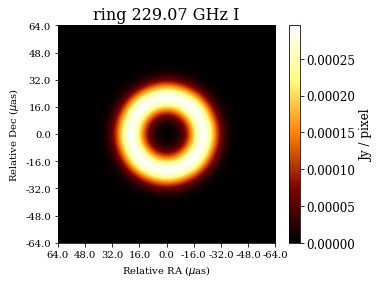

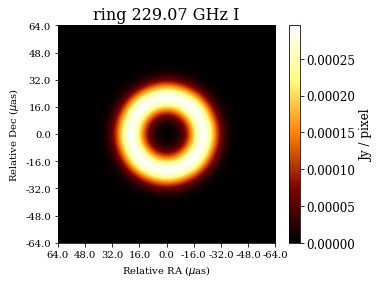

In [3]:
#Load observations
obs_sc = eh.obsdata.load_uvfits(current_path+r'/../synthetic_data/ring_ngeht_averaged.uvfits')
exact_solution = eh.image.load_fits(current_path+r'/../synthetic_data/ring.fits')

exact_solution.display()

In [4]:
#Define prior image as an initial guess
prior = eh.image.make_square(obs_sc, npix, fov) #prior image, make a prior image
prior = prior.add_gauss(zbl, (prior_fwhm, prior_fwhm, 0, 0, 0))

Up to now we followed very close the procedure that we know from tutorial 2. Now we have to define the data fidelity terms and the penalty term. For DoG-HiT we model the image by a dictionary of wavelet functions, use closure quantities as data terms and an l0 penalization on the wavelet coefficients. Moreover, we utilize a total flux constraint. These terms do not have to be allocated manually, this is done by the MinimizationHandler class. As the ngEHT array is very dense, we do not fit the widths of the wavelet functions, but specify them manually for now. Now we can allocate the MinimizationHandler class.

In [5]:
#------------------------------------------------------------------------------
# Prepare Minimization Procedure
#------------------------------------------------------------------------------
#clean beam fwhm
psf_fwhm = 20*eh.RADPERUAS

#threshold for identifying gaps in uv-coverage
threshold = 0.01*10**9
#specify widths of wavelezs manually
widths = np.array([1, 2, 4, 6, 8, 12, 16])
#the final handler for the minimization procedure
handler = MinimizationHandler(psf_fwhm, npix, fov, obs_sc, prior, zbl, rescaling, data_term, cbar_lims, threshold, [], [], widths=widths) 
#widths of wavelet filters
widths = handler.widths

Generating I image...
Generating I image...
Generating I image...


C:\Users\hendr\anaconda3\envs\mrbeam\lib\site-packages\ehtim\obsdata.py:509: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(datalist)


Generating I image...


Now we define a proper initial guess. We use the prior image as an initial guess. Note that we expect an odd number of pixels in case of a small number of pixels to represent wavelets centrally symmetric. Due to the completeness property of wavelets (all the wavelet functions sum to a delta function) it is a reasonable wavelet representation of the prior image to copy the prior image into all scales, in particular for nearly orthogonal wavelets. The data are rescaled to have values in the range ~1 for numerical performance reasons.

In [6]:
img = prior.regrid_image(fov, npix+1)

#Find initial guess by expressing img by dictionary
#Decomposition computed by Landweber inversion
data = handler.convert.ehtim_to_numpy(img)/rescaling

init = np.zeros((len(widths), npix+1, npix+1))
for j in range(len(widths)):
    init[j] = data
init = init.flatten()

The next step is to run the minimization. For DoG-HiT we proposed to use a forward-backward splitting scheme with iterative rescaling to a fixed total flux. This procedure is implemented in regpy and can be called by handler.second_round. The regularization parameter alpha controls the bias between the data fidelity term and the penalty term. The parameter is the step-size parameter for the forward-backward splitting scheme. Furthermore, there is the opportunity to threshold some scales stronger than other scales by the noise_levels parameter. If noise_levels == ones, then the relative weights are taken optimally by the size of the wavelets.

2022-07-27 16:25:54,397 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:25:54,399 INFO Display              :: Penalty--> 3310.17686379213
2022-07-27 16:25:54,663 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:25:54,665 INFO Display              :: Penalty--> 3309.491208020822
2022-07-27 16:25:54,895 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:25:54,896 INFO Display              :: Penalty--> 3309.2724876602542
2022-07-27 16:25:55,119 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:25:55,121 INFO Display              :: Penalty--> 3309.087858564293
2022-07-27 16:25:55,341 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:25:55,343 INFO Display              :: Penalty--> 3308.5489113010685
2022-07-27 16:25:55,558 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:25:55,560 INFO Display              :: Penalty--> 3308.33402141967
2022-07-27 16:25:55,771 INFO CountIterations      :: iteration = 7 / 25
2022

-14003.94365861899
Data Fidelity:  4845.170972236069


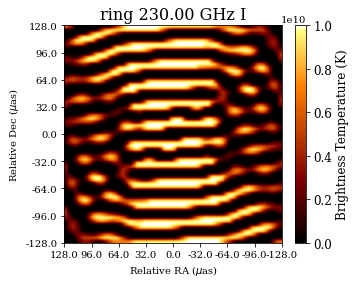

2022-07-27 16:26:00,972 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:26:00,974 INFO Display              :: Penalty--> 2665.3148723486443
2022-07-27 16:26:01,202 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:26:01,205 INFO Display              :: Penalty--> 2637.135169210866
2022-07-27 16:26:01,417 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:26:01,420 INFO Display              :: Penalty--> 2630.932918387022
2022-07-27 16:26:01,621 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:26:01,625 INFO Display              :: Penalty--> 2627.908283509168
2022-07-27 16:26:01,859 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:26:01,861 INFO Display              :: Penalty--> 2622.9991104594264
2022-07-27 16:26:02,068 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:26:02,070 INFO Display              :: Penalty--> 2620.713995581937
2022-07-27 16:26:02,320 INFO CountIterations      :: iteration = 7 / 25
20

1765.770658930902
Data Fidelity:  1885.1155548259414


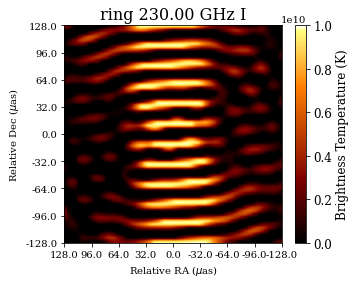

2022-07-27 16:26:06,930 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:26:06,933 INFO Display              :: Penalty--> 1676.7092593608593
2022-07-27 16:26:07,144 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:26:07,146 INFO Display              :: Penalty--> 1663.90362610967
2022-07-27 16:26:07,345 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:26:07,347 INFO Display              :: Penalty--> 1652.243356196184
2022-07-27 16:26:07,559 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:26:07,562 INFO Display              :: Penalty--> 1644.1337373660076
2022-07-27 16:26:07,803 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:26:07,805 INFO Display              :: Penalty--> 1635.04203721059
2022-07-27 16:26:08,075 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:26:08,078 INFO Display              :: Penalty--> 1626.4120023664825
2022-07-27 16:26:08,290 INFO CountIterations      :: iteration = 7 / 25
202

797.3566157804242
Data Fidelity:  1123.136655995213


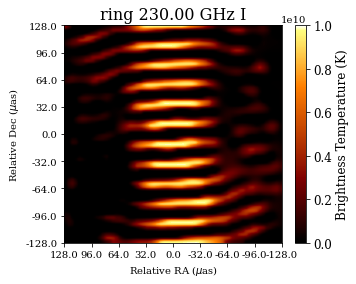

2022-07-27 16:26:12,579 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:26:12,582 INFO Display              :: Penalty--> 1355.630450289074
2022-07-27 16:26:12,818 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:26:12,821 INFO Display              :: Penalty--> 1343.5531395449482
2022-07-27 16:26:13,048 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:26:13,051 INFO Display              :: Penalty--> 1339.4645488605806
2022-07-27 16:26:13,277 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:26:13,279 INFO Display              :: Penalty--> 1335.4495039542128
2022-07-27 16:26:13,493 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:26:13,495 INFO Display              :: Penalty--> 1331.347362221421
2022-07-27 16:26:13,702 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:26:13,705 INFO Display              :: Penalty--> 1326.7296385703883
2022-07-27 16:26:13,919 INFO CountIterations      :: iteration = 7 / 25


618.1194617693126
Data Fidelity:  893.26080711695


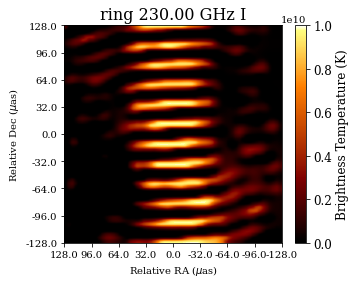

2022-07-27 16:26:18,698 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:26:18,700 INFO Display              :: Penalty--> 1260.4649984752866
2022-07-27 16:26:18,908 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:26:18,910 INFO Display              :: Penalty--> 1259.1524416809375
2022-07-27 16:26:19,124 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:26:19,126 INFO Display              :: Penalty--> 1257.9613110762564
2022-07-27 16:26:19,335 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:26:19,337 INFO Display              :: Penalty--> 1344.6241405829862
2022-07-27 16:26:19,535 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:26:19,536 INFO Display              :: Penalty--> 1323.670143613136
2022-07-27 16:26:19,744 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:26:19,746 INFO Display              :: Penalty--> 1318.6468659453774
2022-07-27 16:26:19,951 INFO CountIterations      :: iteration = 7 / 25

982.7917657417377
Data Fidelity:  1166.8925679593408


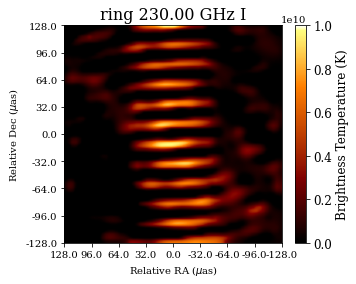

2022-07-27 16:26:24,333 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:26:24,335 INFO Display              :: Penalty--> 1036.437451726225
2022-07-27 16:26:24,538 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:26:24,539 INFO Display              :: Penalty--> 1022.0174210780438
2022-07-27 16:26:24,733 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:26:24,735 INFO Display              :: Penalty--> 1011.2871327715516
2022-07-27 16:26:24,925 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:26:24,927 INFO Display              :: Penalty--> 1006.9324117327285
2022-07-27 16:26:25,114 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:26:25,115 INFO Display              :: Penalty--> 1000.1335200933311
2022-07-27 16:26:25,320 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:26:25,322 INFO Display              :: Penalty--> 995.1387254073658
2022-07-27 16:26:25,510 INFO CountIterations      :: iteration = 7 / 25


655.4817290737985
Data Fidelity:  762.577060618871


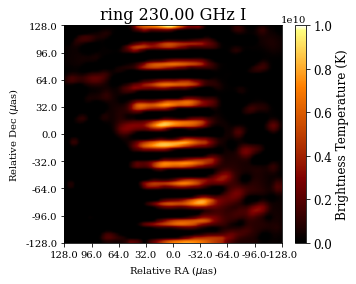

2022-07-27 16:26:29,695 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:26:29,696 INFO Display              :: Penalty--> 879.3679119527211
2022-07-27 16:26:29,907 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:26:29,909 INFO Display              :: Penalty--> 873.0831666569482
2022-07-27 16:26:30,108 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:26:30,109 INFO Display              :: Penalty--> 869.5376843850167
2022-07-27 16:26:30,303 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:26:30,305 INFO Display              :: Penalty--> 867.616465028613
2022-07-27 16:26:30,511 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:26:30,512 INFO Display              :: Penalty--> 863.1495691074955
2022-07-27 16:26:30,716 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:26:30,718 INFO Display              :: Penalty--> 860.8345776483845
2022-07-27 16:26:30,917 INFO CountIterations      :: iteration = 7 / 25
2022-

600.0657056765306
Data Fidelity:  616.9792013604648


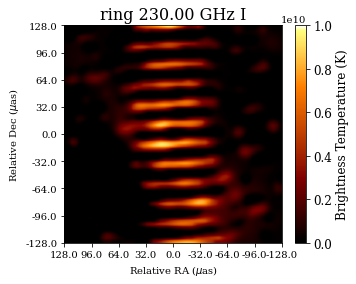

2022-07-27 16:26:35,079 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:26:35,080 INFO Display              :: Penalty--> 814.4231701889258
2022-07-27 16:26:35,297 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:26:35,299 INFO Display              :: Penalty--> 813.4308408751828
2022-07-27 16:26:35,509 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:26:35,510 INFO Display              :: Penalty--> 811.1762789934895
2022-07-27 16:26:35,711 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:26:35,713 INFO Display              :: Penalty--> 810.7147074094853
2022-07-27 16:26:35,906 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:26:35,908 INFO Display              :: Penalty--> 809.4772280068554
2022-07-27 16:26:36,096 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:26:36,098 INFO Display              :: Penalty--> 808.700026095198
2022-07-27 16:26:36,322 INFO CountIterations      :: iteration = 7 / 25
2022-

631.6893296307474
Data Fidelity:  569.400609681881


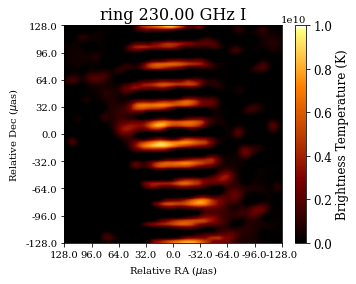

2022-07-27 16:26:40,465 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:26:40,468 INFO Display              :: Penalty--> 775.3946358411558
2022-07-27 16:26:40,671 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:26:40,674 INFO Display              :: Penalty--> 773.2096431531143
2022-07-27 16:26:40,887 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:26:40,889 INFO Display              :: Penalty--> 771.4304425804349
2022-07-27 16:26:41,080 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:26:41,082 INFO Display              :: Penalty--> 770.9619761339259
2022-07-27 16:26:41,294 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:26:41,296 INFO Display              :: Penalty--> 765.0516136022759
2022-07-27 16:26:41,494 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:26:41,496 INFO Display              :: Penalty--> 765.0447187397712
2022-07-27 16:26:41,685 INFO CountIterations      :: iteration = 7 / 25
2022

625.5356133612177
Data Fidelity:  546.8842558600993


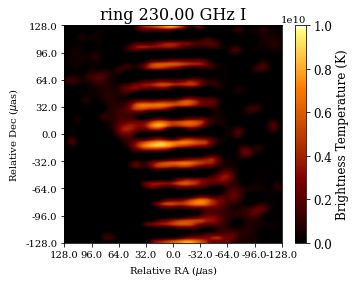

2022-07-27 16:26:46,073 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:26:46,075 INFO Display              :: Penalty--> 734.2459457693076
2022-07-27 16:26:46,292 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:26:46,294 INFO Display              :: Penalty--> 730.3976716560854
2022-07-27 16:26:46,491 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:26:46,493 INFO Display              :: Penalty--> 727.1961256420769
2022-07-27 16:26:46,685 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:26:46,687 INFO Display              :: Penalty--> 725.994797692919
2022-07-27 16:26:46,881 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:26:46,882 INFO Display              :: Penalty--> 725.6060052131319
2022-07-27 16:26:47,083 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:26:47,085 INFO Display              :: Penalty--> 725.3991599159381
2022-07-27 16:26:47,295 INFO CountIterations      :: iteration = 7 / 25
2022-

640.5581562723545
Data Fidelity:  516.6801909795876


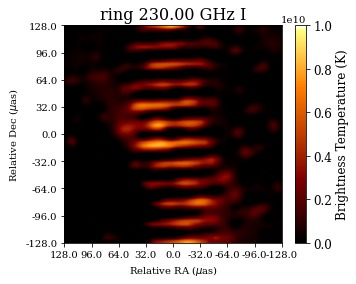

2022-07-27 16:26:51,417 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:26:51,419 INFO Display              :: Penalty--> 680.7718905044793
2022-07-27 16:26:51,612 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:26:51,614 INFO Display              :: Penalty--> 674.3730114255992
2022-07-27 16:26:51,813 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:26:51,816 INFO Display              :: Penalty--> 669.2418806260767
2022-07-27 16:26:52,018 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:26:52,020 INFO Display              :: Penalty--> 665.7907655776506
2022-07-27 16:26:52,229 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:26:52,231 INFO Display              :: Penalty--> 665.465175426208
2022-07-27 16:26:52,423 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:26:52,425 INFO Display              :: Penalty--> 662.746506152322
2022-07-27 16:26:52,670 INFO CountIterations      :: iteration = 7 / 25
2022-0

647.147515053212
Data Fidelity:  492.9052934300628


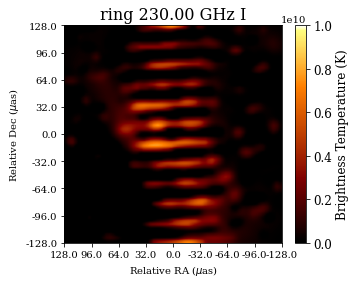

2022-07-27 16:26:56,968 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:26:56,969 INFO Display              :: Penalty--> 612.5414784750471
2022-07-27 16:26:57,180 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:26:57,182 INFO Display              :: Penalty--> 608.3196406493595
2022-07-27 16:26:57,398 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:26:57,400 INFO Display              :: Penalty--> 606.631460531629
2022-07-27 16:26:57,603 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:26:57,605 INFO Display              :: Penalty--> 602.3280329216858
2022-07-27 16:26:57,800 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:26:57,802 INFO Display              :: Penalty--> 601.7252621835637
2022-07-27 16:26:57,993 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:26:57,995 INFO Display              :: Penalty--> 600.9570153232763
2022-07-27 16:26:58,187 INFO CountIterations      :: iteration = 7 / 25
2022-

635.9106819326945
Data Fidelity:  469.7599548686161


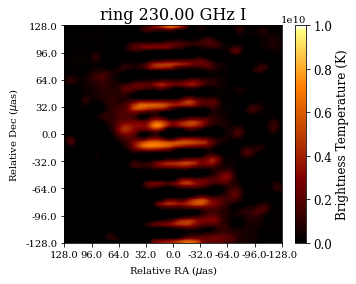

2022-07-27 16:27:02,413 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:27:02,415 INFO Display              :: Penalty--> 544.5248491106431
2022-07-27 16:27:02,615 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:27:02,617 INFO Display              :: Penalty--> 542.7045174615713
2022-07-27 16:27:02,837 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:27:02,839 INFO Display              :: Penalty--> 536.7965597070184
2022-07-27 16:27:03,041 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:27:03,043 INFO Display              :: Penalty--> 542.0152693524278
2022-07-27 16:27:03,230 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:27:03,232 INFO Display              :: Penalty--> 530.2714044231179
2022-07-27 16:27:03,445 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:27:03,448 INFO Display              :: Penalty--> 524.0282531081765
2022-07-27 16:27:03,649 INFO CountIterations      :: iteration = 7 / 25
2022

1244.539791205072
Data Fidelity:  1006.1614155221282


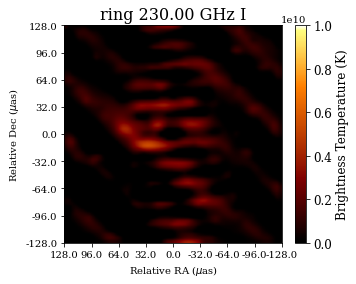

2022-07-27 16:27:07,886 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:27:07,888 INFO Display              :: Penalty--> 315.9246743624464
2022-07-27 16:27:08,081 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:27:08,083 INFO Display              :: Penalty--> 301.41919970751326
2022-07-27 16:27:08,315 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:27:08,318 INFO Display              :: Penalty--> 292.5880426975372
2022-07-27 16:27:08,543 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:27:08,544 INFO Display              :: Penalty--> 277.3155571179815
2022-07-27 16:27:08,744 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:27:08,746 INFO Display              :: Penalty--> 273.4280072767374
2022-07-27 16:27:08,952 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:27:08,953 INFO Display              :: Penalty--> 269.7465383707011
2022-07-27 16:27:09,157 INFO CountIterations      :: iteration = 7 / 25
202

700.4329494337386
Data Fidelity:  455.58973235379267


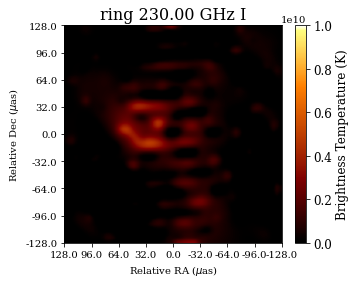

2022-07-27 16:27:13,688 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:27:13,690 INFO Display              :: Penalty--> 159.40186720913363
2022-07-27 16:27:13,935 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:27:13,937 INFO Display              :: Penalty--> 153.20339622043198
2022-07-27 16:27:14,148 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:27:14,150 INFO Display              :: Penalty--> 148.0763079435912
2022-07-27 16:27:14,355 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:27:14,357 INFO Display              :: Penalty--> 140.73865476173182
2022-07-27 16:27:14,559 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:27:14,560 INFO Display              :: Penalty--> 137.83668894460078
2022-07-27 16:27:14,787 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:27:14,789 INFO Display              :: Penalty--> 134.58921390639742
2022-07-27 16:27:15,024 INFO CountIterations      :: iteration = 7 / 25

493.1041143291473
Data Fidelity:  378.67831731043907


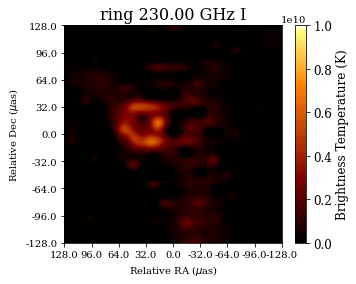

2022-07-27 16:27:19,369 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:27:19,371 INFO Display              :: Penalty--> 101.67742056279292
2022-07-27 16:27:19,560 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:27:19,562 INFO Display              :: Penalty--> 96.59820518427874
2022-07-27 16:27:19,756 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:27:19,758 INFO Display              :: Penalty--> 92.23337417084215
2022-07-27 16:27:19,964 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:27:19,966 INFO Display              :: Penalty--> 90.40125656210718
2022-07-27 16:27:20,164 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:27:20,166 INFO Display              :: Penalty--> 90.38057197459287
2022-07-27 16:27:20,382 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:27:20,384 INFO Display              :: Penalty--> 90.32924355372401
2022-07-27 16:27:20,581 INFO CountIterations      :: iteration = 7 / 25
202

577.3194469241795
Data Fidelity:  170.40504048665485


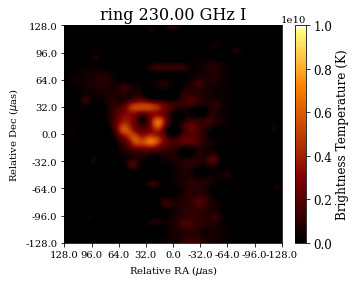

2022-07-27 16:27:25,006 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:27:25,008 INFO Display              :: Penalty--> 81.35215915817955
2022-07-27 16:27:25,201 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:27:25,203 INFO Display              :: Penalty--> 81.06793818176551
2022-07-27 16:27:25,423 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:27:25,425 INFO Display              :: Penalty--> 80.73009107493031
2022-07-27 16:27:25,630 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:27:25,632 INFO Display              :: Penalty--> 80.38726376722573
2022-07-27 16:27:25,837 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:27:25,839 INFO Display              :: Penalty--> 80.38036890472097
2022-07-27 16:27:26,048 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:27:26,050 INFO Display              :: Penalty--> 80.19420819504143
2022-07-27 16:27:26,254 INFO CountIterations      :: iteration = 7 / 25
2022

587.7655799192709
Data Fidelity:  219.7636557623194


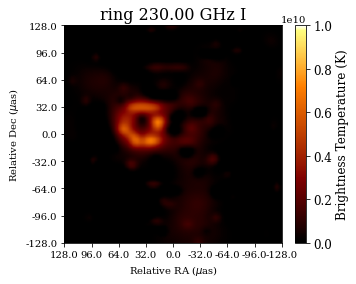

2022-07-27 16:27:30,433 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:27:30,436 INFO Display              :: Penalty--> 67.19743225204917
2022-07-27 16:27:30,634 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:27:30,636 INFO Display              :: Penalty--> 66.51024544497226
2022-07-27 16:27:30,826 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:27:30,827 INFO Display              :: Penalty--> 71.37763821516955
2022-07-27 16:27:31,020 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:27:31,022 INFO Display              :: Penalty--> 65.80161257814136
2022-07-27 16:27:31,228 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:27:31,230 INFO Display              :: Penalty--> 64.59424669987123
2022-07-27 16:27:31,450 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:27:31,452 INFO Display              :: Penalty--> 64.35522537765513
2022-07-27 16:27:31,643 INFO CountIterations      :: iteration = 7 / 25
2022

597.2142121319364
Data Fidelity:  74.98958670240103


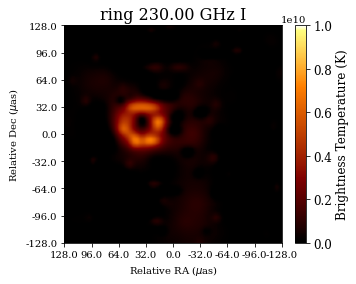

2022-07-27 16:27:35,830 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:27:35,832 INFO Display              :: Penalty--> 53.92423777256638
2022-07-27 16:27:36,027 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:27:36,029 INFO Display              :: Penalty--> 53.82158093082869
2022-07-27 16:27:36,237 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:27:36,240 INFO Display              :: Penalty--> 52.84174724906379
2022-07-27 16:27:36,438 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:27:36,441 INFO Display              :: Penalty--> 51.82667315894119
2022-07-27 16:27:36,649 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:27:36,651 INFO Display              :: Penalty--> 51.379274347863515
2022-07-27 16:27:36,854 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:27:36,855 INFO Display              :: Penalty--> 50.57755679157333
2022-07-27 16:27:37,051 INFO CountIterations      :: iteration = 7 / 25
202

578.8278510459489
Data Fidelity:  47.76927916814625


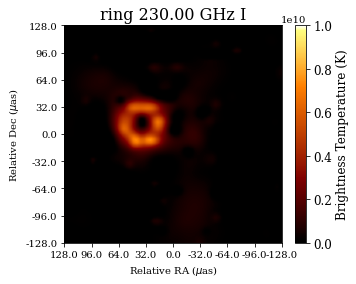

2022-07-27 16:27:41,350 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:27:41,352 INFO Display              :: Penalty--> 43.09779918997428
2022-07-27 16:27:41,553 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:27:41,555 INFO Display              :: Penalty--> 43.05336563161021
2022-07-27 16:27:41,757 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:27:41,758 INFO Display              :: Penalty--> 43.02578618159113
2022-07-27 16:27:41,958 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:27:41,959 INFO Display              :: Penalty--> 42.68104421225116
2022-07-27 16:27:42,152 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:27:42,154 INFO Display              :: Penalty--> 41.76403038886306
2022-07-27 16:27:42,346 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:27:42,348 INFO Display              :: Penalty--> 41.176053570220745
2022-07-27 16:27:42,557 INFO CountIterations      :: iteration = 7 / 25
202

594.8090383242743
Data Fidelity:  37.64705525663672


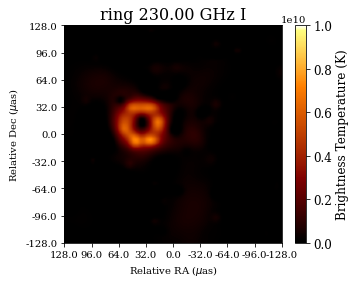

2022-07-27 16:27:46,796 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:27:46,798 INFO Display              :: Penalty--> 36.94644887454798
2022-07-27 16:27:46,993 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:27:46,995 INFO Display              :: Penalty--> 36.70934279191654
2022-07-27 16:27:47,187 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:27:47,189 INFO Display              :: Penalty--> 36.32016726421249
2022-07-27 16:27:47,388 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:27:47,390 INFO Display              :: Penalty--> 35.80650174145491
2022-07-27 16:27:47,586 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:27:47,589 INFO Display              :: Penalty--> 35.2863244041095
2022-07-27 16:27:47,777 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:27:47,780 INFO Display              :: Penalty--> 35.203203006135325
2022-07-27 16:27:47,971 INFO CountIterations      :: iteration = 7 / 25
2022

587.9559679759327
Data Fidelity:  31.08424320346908


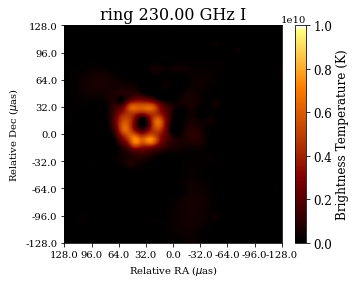

2022-07-27 16:27:52,174 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:27:52,176 INFO Display              :: Penalty--> 32.89036372934672
2022-07-27 16:27:52,383 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:27:52,385 INFO Display              :: Penalty--> 32.85205893765354
2022-07-27 16:27:52,627 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:27:52,628 INFO Display              :: Penalty--> 32.45637159536166
2022-07-27 16:27:52,810 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:27:52,811 INFO Display              :: Penalty--> 32.39546697656952
2022-07-27 16:27:53,022 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:27:53,025 INFO Display              :: Penalty--> 31.88218450172888
2022-07-27 16:27:53,225 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:27:53,228 INFO Display              :: Penalty--> 31.807107110010268
2022-07-27 16:27:53,424 INFO CountIterations      :: iteration = 7 / 25
202

590.0254765534406
Data Fidelity:  22.945452734970093


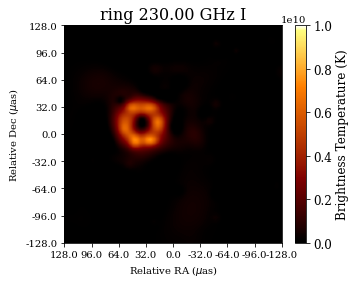

2022-07-27 16:27:57,681 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:27:57,683 INFO Display              :: Penalty--> 28.808998577526502
2022-07-27 16:27:57,878 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:27:57,881 INFO Display              :: Penalty--> 28.802869810855597
2022-07-27 16:27:58,081 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:27:58,083 INFO Display              :: Penalty--> 28.758053204574594
2022-07-27 16:27:58,297 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:27:58,299 INFO Display              :: Penalty--> 28.711321358708922
2022-07-27 16:27:58,492 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:27:58,494 INFO Display              :: Penalty--> 28.67876228576973
2022-07-27 16:27:58,702 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:27:58,704 INFO Display              :: Penalty--> 28.637776158658042
2022-07-27 16:27:58,892 INFO CountIterations      :: iteration = 7 / 25

591.1851466278391
Data Fidelity:  19.86633679296913


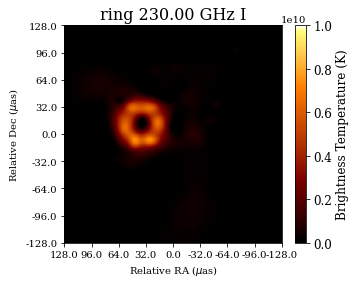

2022-07-27 16:28:03,110 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:28:03,112 INFO Display              :: Penalty--> 27.050045432722563
2022-07-27 16:28:03,322 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:28:03,324 INFO Display              :: Penalty--> 27.050045432722563
2022-07-27 16:28:03,537 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:28:03,539 INFO Display              :: Penalty--> 27.047364097304044
2022-07-27 16:28:03,731 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:28:03,733 INFO Display              :: Penalty--> 26.98722557434577
2022-07-27 16:28:03,936 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:28:03,938 INFO Display              :: Penalty--> 26.93589715347692
2022-07-27 16:28:04,154 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:28:04,156 INFO Display              :: Penalty--> 26.84932832425036
2022-07-27 16:28:04,365 INFO CountIterations      :: iteration = 7 / 25
2

593.8270114226623
Data Fidelity:  16.020353965054355


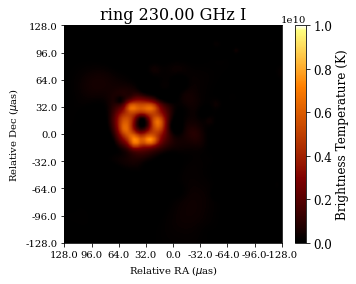

2022-07-27 16:28:08,795 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:28:08,797 INFO Display              :: Penalty--> 25.87064263033772
2022-07-27 16:28:09,010 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:28:09,012 INFO Display              :: Penalty--> 25.833103934478416
2022-07-27 16:28:09,252 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:28:09,254 INFO Display              :: Penalty--> 25.656519422722184
2022-07-27 16:28:09,540 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:28:09,542 INFO Display              :: Penalty--> 25.636983978958664
2022-07-27 16:28:09,790 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:28:09,793 INFO Display              :: Penalty--> 25.402559231745744
2022-07-27 16:28:10,004 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:28:10,006 INFO Display              :: Penalty--> 25.364254440052576
2022-07-27 16:28:10,220 INFO CountIterations      :: iteration = 7 / 25

592.1214225597773
Data Fidelity:  14.010362935313301


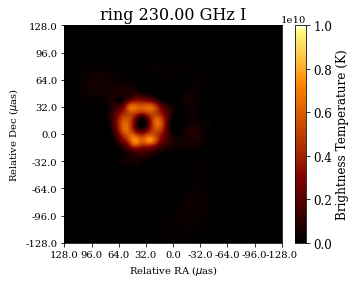

In [7]:
#Regularization parameters
alpha = 0.5
tau = 5
noise_levels = np.ones(len(widths))

wtfcts = handler.second_round(init, tau, alpha*noise_levels, maxiter=25, max_iterations=25, display=True)

reco = handler.op(wtfcts)        
img = handler.wrapper.formatoutput(np.maximum(0, reco))

The recovered solution during the first iterations represents noise-like fringes. Note that this is caused by the large stepsize parameter causing divergence. However, the coercivity of the penalty term brings the solution back in the right ballpark. After some time the forward-backward splitting starts to converge and recovers a ring-like feature. Significant improvements in speed and accuracy are possible by reasonable initial guesses and will be matter of tutorial 5 and tutorial 6. To achieve global convergence, we blur the reconstruction by the instrumental resolution and repeat the minimization with smaller stepsizes  from this initial guess.

2022-07-27 16:28:27,987 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:28:27,989 INFO Display              :: Penalty--> 655.1146136255816
2022-07-27 16:28:28,196 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:28:28,198 INFO Display              :: Penalty--> 602.7279706907252
2022-07-27 16:28:28,396 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:28:28,398 INFO Display              :: Penalty--> 588.9370846634156
2022-07-27 16:28:28,605 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:28:28,607 INFO Display              :: Penalty--> 575.7023300997688
2022-07-27 16:28:28,816 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:28:28,818 INFO Display              :: Penalty--> 557.0357963609858
2022-07-27 16:28:29,029 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:28:29,031 INFO Display              :: Penalty--> 549.1194975243797
2022-07-27 16:28:29,232 INFO CountIterations      :: iteration = 7 / 25
2022

1268.2844034966154
Data Fidelity:  289.2651768320908


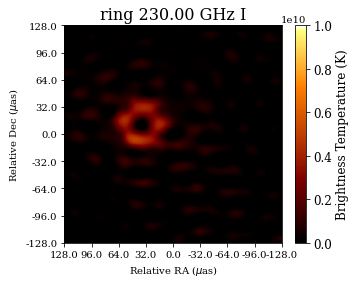

2022-07-27 16:28:33,591 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:28:33,593 INFO Display              :: Penalty--> 170.08326863299325
2022-07-27 16:28:33,800 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:28:33,802 INFO Display              :: Penalty--> 152.41398336170954
2022-07-27 16:28:34,015 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:28:34,016 INFO Display              :: Penalty--> 138.74376320772603
2022-07-27 16:28:34,209 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:28:34,211 INFO Display              :: Penalty--> 127.72632924181482
2022-07-27 16:28:34,433 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:28:34,435 INFO Display              :: Penalty--> 121.35564493260779
2022-07-27 16:28:34,665 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:28:34,667 INFO Display              :: Penalty--> 155.4907595180414
2022-07-27 16:28:34,884 INFO CountIterations      :: iteration = 7 / 25

437.9062544682329
Data Fidelity:  25.883061617704172


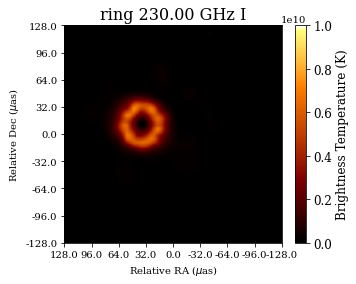

2022-07-27 16:28:39,240 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:28:39,242 INFO Display              :: Penalty--> 75.90323632176238
2022-07-27 16:28:39,476 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:28:39,478 INFO Display              :: Penalty--> 75.90323632176238
2022-07-27 16:28:39,714 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:28:39,715 INFO Display              :: Penalty--> 75.90323632176238
2022-07-27 16:28:39,958 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:28:39,960 INFO Display              :: Penalty--> 75.89557536342375
2022-07-27 16:28:40,174 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:28:40,176 INFO Display              :: Penalty--> 75.88791440508511
2022-07-27 16:28:40,406 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:28:40,408 INFO Display              :: Penalty--> 75.86493153006921
2022-07-27 16:28:40,608 INFO CountIterations      :: iteration = 7 / 25
2022

564.8918695352146
Data Fidelity:  8.57258304294351


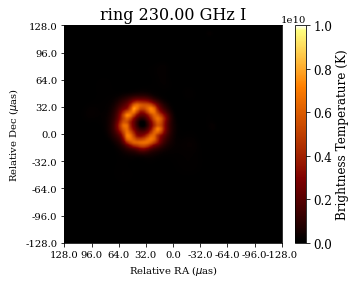

2022-07-27 16:28:45,127 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:28:45,129 INFO Display              :: Penalty--> 73.67696240650469
2022-07-27 16:28:45,344 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:28:45,346 INFO Display              :: Penalty--> 73.67696240650469
2022-07-27 16:28:45,559 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:28:45,562 INFO Display              :: Penalty--> 73.63099665647287
2022-07-27 16:28:45,769 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:28:45,772 INFO Display              :: Penalty--> 73.60456635020459
2022-07-27 16:28:45,995 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:28:45,997 INFO Display              :: Penalty--> 73.52221104806429
2022-07-27 16:28:46,220 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:28:46,221 INFO Display              :: Penalty--> 73.43449307508693
2022-07-27 16:28:46,431 INFO CountIterations      :: iteration = 7 / 25
2022

580.5695409851639
Data Fidelity:  4.727103947330611


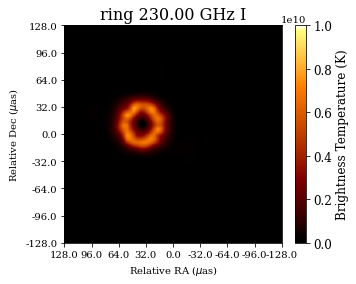

2022-07-27 16:28:50,697 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:28:50,699 INFO Display              :: Penalty--> 71.96167499038314
2022-07-27 16:28:50,902 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:28:50,903 INFO Display              :: Penalty--> 71.95822755913075
2022-07-27 16:28:51,103 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:28:51,105 INFO Display              :: Penalty--> 71.92873286952701
2022-07-27 16:28:51,303 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:28:51,305 INFO Display              :: Penalty--> 71.92107191118838
2022-07-27 16:28:51,509 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:28:51,510 INFO Display              :: Penalty--> 71.90766523409577
2022-07-27 16:28:51,708 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:28:51,710 INFO Display              :: Penalty--> 71.88698064658146
2022-07-27 16:28:51,913 INFO CountIterations      :: iteration = 7 / 25
2022

587.442102799235
Data Fidelity:  3.3149490428986477


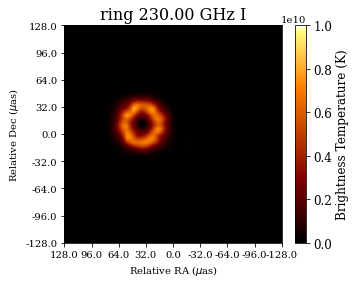

2022-07-27 16:28:56,193 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:28:56,194 INFO Display              :: Penalty--> 71.06649200851379
2022-07-27 16:28:56,391 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:28:56,394 INFO Display              :: Penalty--> 71.05883105017516
2022-07-27 16:28:56,596 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:28:56,598 INFO Display              :: Penalty--> 71.05117009183652
2022-07-27 16:28:56,793 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:28:56,795 INFO Display              :: Penalty--> 71.05117009183652
2022-07-27 16:28:56,984 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:28:56,986 INFO Display              :: Penalty--> 71.04350913349789
2022-07-27 16:28:57,194 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:28:57,195 INFO Display              :: Penalty--> 71.0327837918238
2022-07-27 16:28:57,389 INFO CountIterations      :: iteration = 7 / 25
2022-

591.143626483637
Data Fidelity:  2.481504930845241


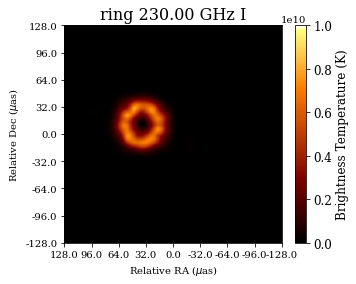

2022-07-27 16:29:01,522 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:29:01,524 INFO Display              :: Penalty--> 70.51490300813215
2022-07-27 16:29:01,720 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:29:01,721 INFO Display              :: Penalty--> 70.51145557687977
2022-07-27 16:29:01,932 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:29:01,933 INFO Display              :: Penalty--> 70.50877424146125
2022-07-27 16:29:02,131 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:29:02,133 INFO Display              :: Penalty--> 70.50609290604272
2022-07-27 16:29:02,334 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:29:02,335 INFO Display              :: Penalty--> 70.48732355811305
2022-07-27 16:29:02,540 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:29:02,543 INFO Display              :: Penalty--> 70.45974410809399
2022-07-27 16:29:02,748 INFO CountIterations      :: iteration = 7 / 25
2022

593.4838008284305
Data Fidelity:  2.023943097425709


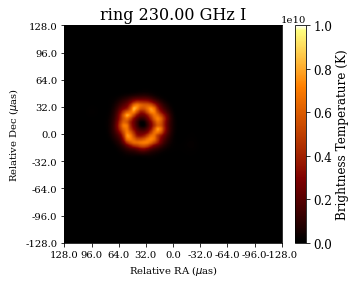

2022-07-27 16:29:06,949 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:29:06,952 INFO Display              :: Penalty--> 70.15483796621638
2022-07-27 16:29:07,158 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:29:07,161 INFO Display              :: Penalty--> 70.15215663079785
2022-07-27 16:29:07,347 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:29:07,349 INFO Display              :: Penalty--> 70.14334652870842
2022-07-27 16:29:07,547 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:29:07,548 INFO Display              :: Penalty--> 70.13989909745604
2022-07-27 16:29:07,745 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:29:07,747 INFO Display              :: Penalty--> 70.12457718077877
2022-07-27 16:29:07,967 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:29:07,971 INFO Display              :: Penalty--> 70.12112974952639
2022-07-27 16:29:08,160 INFO CountIterations      :: iteration = 7 / 25
2022

595.1405491774708
Data Fidelity:  1.7215116092373683


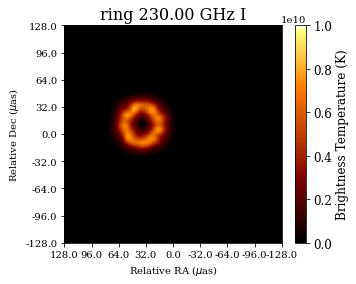

2022-07-27 16:29:12,280 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:29:12,282 INFO Display              :: Penalty--> 69.83460990766147
2022-07-27 16:29:12,465 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:29:12,467 INFO Display              :: Penalty--> 69.83460990766147
2022-07-27 16:29:12,663 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:29:12,665 INFO Display              :: Penalty--> 69.82579980557205
2022-07-27 16:29:12,860 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:29:12,862 INFO Display              :: Penalty--> 69.82235237431966
2022-07-27 16:29:13,062 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:29:13,064 INFO Display              :: Penalty--> 69.82235237431966
2022-07-27 16:29:13,277 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:29:13,279 INFO Display              :: Penalty--> 69.81967103890115
2022-07-27 16:29:13,481 INFO CountIterations      :: iteration = 7 / 25
2022

595.9146796807219
Data Fidelity:  1.5673486044001352


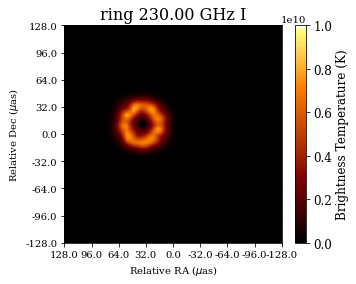

2022-07-27 16:29:17,895 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:29:17,897 INFO Display              :: Penalty--> 69.43087740321549
2022-07-27 16:29:18,097 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:29:18,098 INFO Display              :: Penalty--> 69.43087740321549
2022-07-27 16:29:18,314 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:29:18,316 INFO Display              :: Penalty--> 69.43087740321549
2022-07-27 16:29:18,531 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:29:18,533 INFO Display              :: Penalty--> 69.40904367195039
2022-07-27 16:29:18,738 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:29:18,740 INFO Display              :: Penalty--> 69.40904367195039
2022-07-27 16:29:18,944 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:29:18,946 INFO Display              :: Penalty--> 69.40904367195039
2022-07-27 16:29:19,147 INFO CountIterations      :: iteration = 7 / 25
2022

596.6602736947777
Data Fidelity:  1.4236966354524245


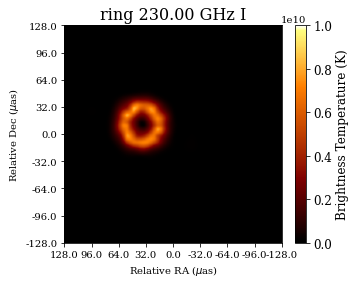

2022-07-27 16:29:23,615 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:29:23,617 INFO Display              :: Penalty--> 69.2244145759893
2022-07-27 16:29:23,808 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:29:23,810 INFO Display              :: Penalty--> 69.2244145759893
2022-07-27 16:29:24,014 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:29:24,017 INFO Display              :: Penalty--> 69.22096714473692
2022-07-27 16:29:24,227 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:29:24,230 INFO Display              :: Penalty--> 69.21330618639828
2022-07-27 16:29:24,444 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:29:24,447 INFO Display              :: Penalty--> 69.19989950930568
2022-07-27 16:29:24,662 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:29:24,665 INFO Display              :: Penalty--> 69.19989950930568
2022-07-27 16:29:24,889 INFO CountIterations      :: iteration = 7 / 25
2022-0

597.683475573283
Data Fidelity:  1.3385244867444506


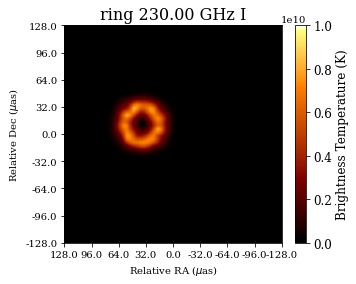

2022-07-27 16:29:29,237 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:29:29,239 INFO Display              :: Penalty--> 69.01143993417529
2022-07-27 16:29:29,442 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:29:29,444 INFO Display              :: Penalty--> 69.00033154458427
2022-07-27 16:29:29,646 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:29:29,648 INFO Display              :: Penalty--> 68.95934541747258
2022-07-27 16:29:29,871 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:29:29,872 INFO Display              :: Penalty--> 68.95168445913394
2022-07-27 16:29:30,074 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:29:30,075 INFO Display              :: Penalty--> 68.94095911745985
2022-07-27 16:29:30,265 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:29:30,267 INFO Display              :: Penalty--> 68.94095911745985
2022-07-27 16:29:30,457 INFO CountIterations      :: iteration = 7 / 25
2022

597.7850332771961
Data Fidelity:  1.2741345486851103


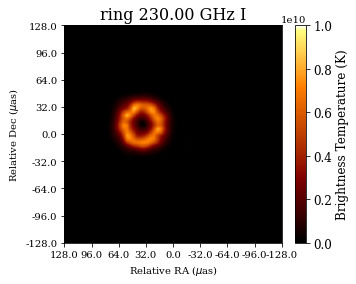

2022-07-27 16:29:34,682 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:29:34,684 INFO Display              :: Penalty--> 68.81914987987557
2022-07-27 16:29:34,894 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:29:34,896 INFO Display              :: Penalty--> 68.81914987987557
2022-07-27 16:29:35,106 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:29:35,108 INFO Display              :: Penalty--> 68.80842453820149
2022-07-27 16:29:35,328 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:29:35,330 INFO Display              :: Penalty--> 68.80842453820149
2022-07-27 16:29:35,564 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:29:35,566 INFO Display              :: Penalty--> 68.80842453820149
2022-07-27 16:29:35,790 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:29:35,792 INFO Display              :: Penalty--> 68.80842453820149
2022-07-27 16:29:35,991 INFO CountIterations      :: iteration = 7 / 25
2022

598.5440090594226
Data Fidelity:  1.2266018849956164


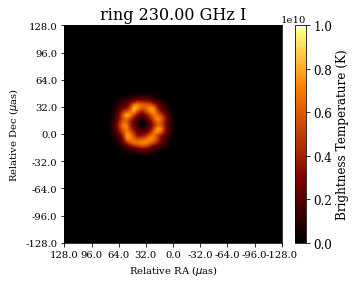

2022-07-27 16:29:40,484 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:29:40,486 INFO Display              :: Penalty--> 68.53875938263087
2022-07-27 16:29:40,690 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:29:40,691 INFO Display              :: Penalty--> 68.53531195137847
2022-07-27 16:29:40,888 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:29:40,890 INFO Display              :: Penalty--> 68.51386126803031
2022-07-27 16:29:41,107 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:29:41,109 INFO Display              :: Penalty--> 68.4920275367652
2022-07-27 16:29:41,317 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:29:41,319 INFO Display              :: Penalty--> 68.4920275367652
2022-07-27 16:29:41,535 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:29:41,536 INFO Display              :: Penalty--> 68.4920275367652
2022-07-27 16:29:41,736 INFO CountIterations      :: iteration = 7 / 25
2022-07

598.4179352670385
Data Fidelity:  1.1808350267971828


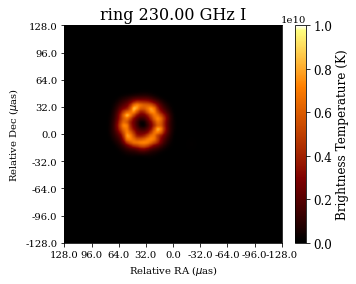

2022-07-27 16:29:46,285 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:29:46,287 INFO Display              :: Penalty--> 68.42997377422226
2022-07-27 16:29:46,497 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:29:46,498 INFO Display              :: Penalty--> 68.42997377422226
2022-07-27 16:29:46,702 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:29:46,704 INFO Display              :: Penalty--> 68.42729243880373
2022-07-27 16:29:46,912 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:29:46,914 INFO Display              :: Penalty--> 68.42729243880373
2022-07-27 16:29:47,124 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:29:47,127 INFO Display              :: Penalty--> 68.42729243880373
2022-07-27 16:29:47,330 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:29:47,332 INFO Display              :: Penalty--> 68.42729243880373
2022-07-27 16:29:47,563 INFO CountIterations      :: iteration = 7 / 25
2022

598.7869296217251
Data Fidelity:  1.1469041828168178


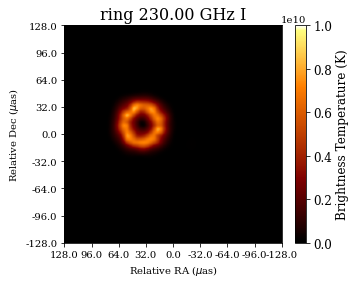

2022-07-27 16:29:51,945 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:29:51,947 INFO Display              :: Penalty--> 68.38285888043966
2022-07-27 16:29:52,152 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:29:52,154 INFO Display              :: Penalty--> 68.38285888043966
2022-07-27 16:29:52,347 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:29:52,349 INFO Display              :: Penalty--> 68.38017754502114
2022-07-27 16:29:52,562 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:29:52,563 INFO Display              :: Penalty--> 68.38017754502114
2022-07-27 16:29:52,760 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:29:52,762 INFO Display              :: Penalty--> 68.38017754502114
2022-07-27 16:29:52,957 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:29:52,958 INFO Display              :: Penalty--> 68.38017754502114
2022-07-27 16:29:53,165 INFO CountIterations      :: iteration = 7 / 25
2022

598.8391801805433
Data Fidelity:  1.1170344668857717


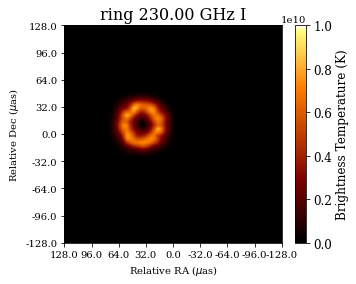

2022-07-27 16:29:57,533 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:29:57,534 INFO Display              :: Penalty--> 68.33536093874015
2022-07-27 16:29:57,744 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:29:57,746 INFO Display              :: Penalty--> 68.33536093874015
2022-07-27 16:29:57,942 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:29:57,944 INFO Display              :: Penalty--> 68.33536093874015
2022-07-27 16:29:58,140 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:29:58,142 INFO Display              :: Penalty--> 68.3047171053856
2022-07-27 16:29:58,342 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:29:58,344 INFO Display              :: Penalty--> 68.29705614704697
2022-07-27 16:29:58,565 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:29:58,567 INFO Display              :: Penalty--> 68.29705614704697
2022-07-27 16:29:58,767 INFO CountIterations      :: iteration = 7 / 25
2022-

598.8826070030809
Data Fidelity:  1.088864338543554


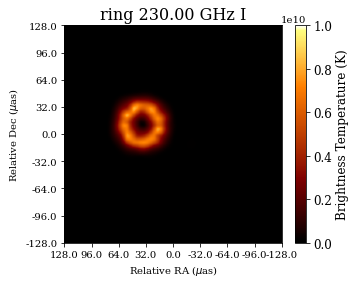

2022-07-27 16:30:04,617 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:30:04,619 INFO Display              :: Penalty--> 68.22006351574369
2022-07-27 16:30:04,821 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:30:04,822 INFO Display              :: Penalty--> 68.22006351574369
2022-07-27 16:30:05,023 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:30:05,024 INFO Display              :: Penalty--> 68.22006351574369
2022-07-27 16:30:05,231 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:30:05,233 INFO Display              :: Penalty--> 68.22006351574369
2022-07-27 16:30:05,431 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:30:05,433 INFO Display              :: Penalty--> 68.22006351574369
2022-07-27 16:30:05,627 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:30:05,629 INFO Display              :: Penalty--> 68.22006351574369
2022-07-27 16:30:05,833 INFO CountIterations      :: iteration = 7 / 25
2022

599.0317186769302
Data Fidelity:  1.061962671391818


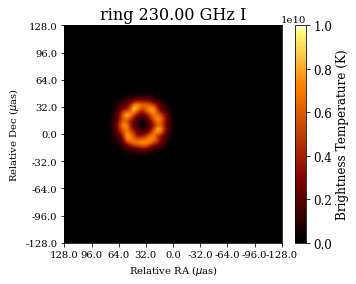

2022-07-27 16:30:10,188 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:30:10,189 INFO Display              :: Penalty--> 68.09480684690703
2022-07-27 16:30:10,387 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:30:10,388 INFO Display              :: Penalty--> 68.09480684690703
2022-07-27 16:30:10,597 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:30:10,599 INFO Display              :: Penalty--> 68.0641630135525
2022-07-27 16:30:10,815 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:30:10,817 INFO Display              :: Penalty--> 68.0641630135525
2022-07-27 16:30:11,010 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:30:11,013 INFO Display              :: Penalty--> 68.0641630135525
2022-07-27 16:30:11,222 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:30:11,224 INFO Display              :: Penalty--> 68.0641630135525
2022-07-27 16:30:11,440 INFO CountIterations      :: iteration = 7 / 25
2022-07-

598.9424484047481
Data Fidelity:  1.0409474587098146


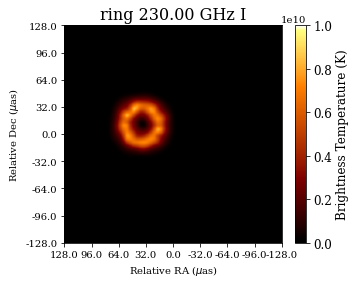

2022-07-27 16:30:15,634 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:30:15,636 INFO Display              :: Penalty--> 68.03313613228104
2022-07-27 16:30:15,835 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:30:15,837 INFO Display              :: Penalty--> 68.03313613228104
2022-07-27 16:30:16,032 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:30:16,034 INFO Display              :: Penalty--> 68.02547517394241
2022-07-27 16:30:16,245 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:30:16,247 INFO Display              :: Penalty--> 68.02547517394241
2022-07-27 16:30:16,448 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:30:16,451 INFO Display              :: Penalty--> 68.01781421560376
2022-07-27 16:30:16,658 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:30:16,661 INFO Display              :: Penalty--> 68.01513288018523
2022-07-27 16:30:16,860 INFO CountIterations      :: iteration = 7 / 25
2022

599.3201034594969
Data Fidelity:  1.022640776235248


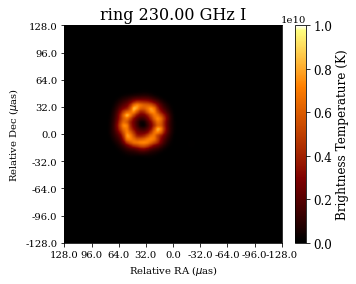

2022-07-27 16:30:20,978 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:30:20,981 INFO Display              :: Penalty--> 67.99866181975717
2022-07-27 16:30:21,176 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:30:21,178 INFO Display              :: Penalty--> 67.99521438850478
2022-07-27 16:30:21,374 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:30:21,375 INFO Display              :: Penalty--> 67.99521438850478
2022-07-27 16:30:21,569 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:30:21,571 INFO Display              :: Penalty--> 67.99521438850478
2022-07-27 16:30:21,761 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:30:21,764 INFO Display              :: Penalty--> 67.9917669572524
2022-07-27 16:30:21,972 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:30:21,973 INFO Display              :: Penalty--> 67.98908562183388
2022-07-27 16:30:22,169 INFO CountIterations      :: iteration = 7 / 25
2022-

599.422666512115
Data Fidelity:  1.005887471967326


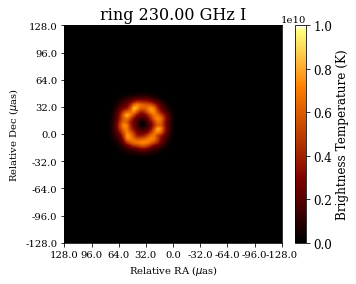

2022-07-27 16:30:26,351 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:30:26,353 INFO Display              :: Penalty--> 67.97031627390423
2022-07-27 16:30:26,558 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:30:26,560 INFO Display              :: Penalty--> 67.9626553155656
2022-07-27 16:30:26,752 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:30:26,754 INFO Display              :: Penalty--> 67.9626553155656
2022-07-27 16:30:26,946 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:30:26,948 INFO Display              :: Penalty--> 67.9626553155656
2022-07-27 16:30:27,143 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:30:27,145 INFO Display              :: Penalty--> 67.9626553155656
2022-07-27 16:30:27,343 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:30:27,345 INFO Display              :: Penalty--> 67.95920788431322
2022-07-27 16:30:27,543 INFO CountIterations      :: iteration = 7 / 25
2022-07-

599.3620135423469
Data Fidelity:  0.9895261180278979


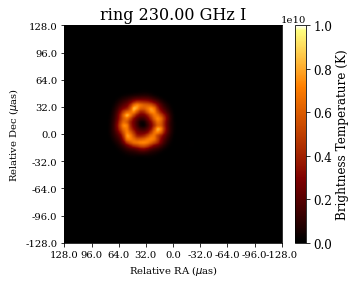

2022-07-27 16:30:31,769 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:30:31,771 INFO Display              :: Penalty--> 67.85808323424325
2022-07-27 16:30:31,960 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:30:31,962 INFO Display              :: Penalty--> 67.82743940088871
2022-07-27 16:30:32,149 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:30:32,151 INFO Display              :: Penalty--> 67.82743940088871
2022-07-27 16:30:32,356 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:30:32,358 INFO Display              :: Penalty--> 67.82743940088871
2022-07-27 16:30:32,558 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:30:32,560 INFO Display              :: Penalty--> 67.82475806547019
2022-07-27 16:30:32,757 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:30:32,760 INFO Display              :: Penalty--> 67.82475806547019
2022-07-27 16:30:32,967 INFO CountIterations      :: iteration = 7 / 25
2022

599.3900529415561
Data Fidelity:  0.976351516444645


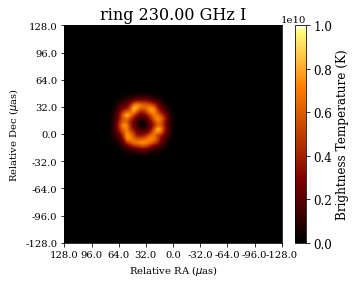

2022-07-27 16:30:37,126 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:30:37,128 INFO Display              :: Penalty--> 67.72133512789864
2022-07-27 16:30:37,324 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:30:37,325 INFO Display              :: Penalty--> 67.72133512789864
2022-07-27 16:30:37,559 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:30:37,561 INFO Display              :: Penalty--> 67.72133512789864
2022-07-27 16:30:37,754 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:30:37,756 INFO Display              :: Penalty--> 67.71367416956001
2022-07-27 16:30:37,977 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:30:37,979 INFO Display              :: Penalty--> 67.71367416956001
2022-07-27 16:30:38,181 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:30:38,182 INFO Display              :: Penalty--> 67.71367416956001
2022-07-27 16:30:38,381 INFO CountIterations      :: iteration = 7 / 25
2022

599.4888101070485
Data Fidelity:  0.9641743495134503


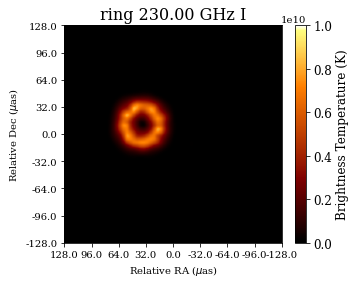

2022-07-27 16:30:42,627 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:30:42,629 INFO Display              :: Penalty--> 67.65353564660174
2022-07-27 16:30:42,826 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:30:42,827 INFO Display              :: Penalty--> 67.65353564660174
2022-07-27 16:30:43,036 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:30:43,038 INFO Display              :: Penalty--> 67.65008821534936
2022-07-27 16:30:43,233 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:30:43,236 INFO Display              :: Penalty--> 67.65008821534936
2022-07-27 16:30:43,423 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:30:43,425 INFO Display              :: Penalty--> 67.65008821534936
2022-07-27 16:30:43,631 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:30:43,632 INFO Display              :: Penalty--> 67.64664078409697
2022-07-27 16:30:43,823 INFO CountIterations      :: iteration = 7 / 25
2022

599.3453174524218
Data Fidelity:  0.9521791394588509


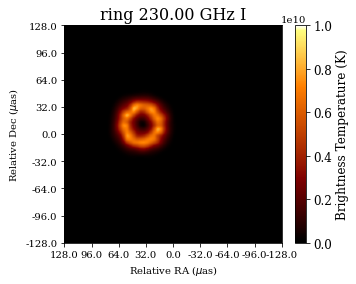

2022-07-27 16:30:48,072 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:30:48,074 INFO Display              :: Penalty--> 447.51696225828687
2022-07-27 16:30:48,284 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:30:48,285 INFO Display              :: Penalty--> 417.36160867302874
2022-07-27 16:30:48,495 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:30:48,496 INFO Display              :: Penalty--> 407.09738897133957
2022-07-27 16:30:48,707 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:30:48,709 INFO Display              :: Penalty--> 393.5068439399763
2022-07-27 16:30:48,905 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:30:48,907 INFO Display              :: Penalty--> 383.6054247273431
2022-07-27 16:30:49,153 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:30:49,154 INFO Display              :: Penalty--> 374.77323431040054
2022-07-27 16:30:49,434 INFO CountIterations      :: iteration = 7 / 25


528.8698760204298
Data Fidelity:  72.8543587330243


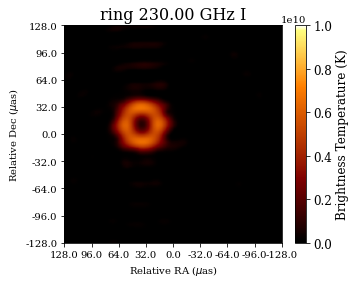

2022-07-27 16:30:54,079 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:30:54,081 INFO Display              :: Penalty--> 273.71872173138496
2022-07-27 16:30:54,292 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:30:54,294 INFO Display              :: Penalty--> 273.71872173138496
2022-07-27 16:30:54,505 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:30:54,507 INFO Display              :: Penalty--> 273.6574340646759
2022-07-27 16:30:54,716 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:30:54,718 INFO Display              :: Penalty--> 273.0997180314712
2022-07-27 16:30:54,936 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:30:54,938 INFO Display              :: Penalty--> 272.81166657588784
2022-07-27 16:30:55,163 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:30:55,164 INFO Display              :: Penalty--> 271.9275942954066
2022-07-27 16:30:55,364 INFO CountIterations      :: iteration = 7 / 25
2

589.1875546078877
Data Fidelity:  26.315113122020946


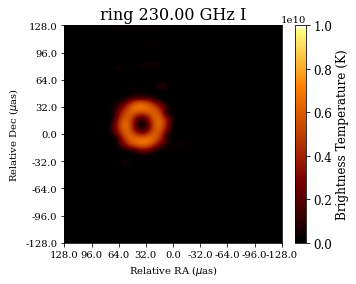

2022-07-27 16:31:00,073 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:31:00,075 INFO Display              :: Penalty--> 236.1646355583424
2022-07-27 16:31:00,276 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:31:00,277 INFO Display              :: Penalty--> 234.7488950809571
2022-07-27 16:31:00,481 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:31:00,483 INFO Display              :: Penalty--> 232.9547044175418
2022-07-27 16:31:00,692 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:31:00,693 INFO Display              :: Penalty--> 231.85152988447422
2022-07-27 16:31:00,904 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:31:00,905 INFO Display              :: Penalty--> 229.03551579566135
2022-07-27 16:31:01,110 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:31:01,112 INFO Display              :: Penalty--> 227.7132384320581
2022-07-27 16:31:01,319 INFO CountIterations      :: iteration = 7 / 25
20

590.5479080967375
Data Fidelity:  5.9343150244061045


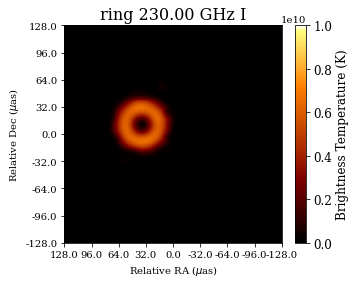

2022-07-27 16:31:05,721 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:31:05,724 INFO Display              :: Penalty--> 205.47905450493326
2022-07-27 16:31:05,924 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:31:05,926 INFO Display              :: Penalty--> 204.9826261384376
2022-07-27 16:31:06,138 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:31:06,140 INFO Display              :: Penalty--> 204.8171500162724
2022-07-27 16:31:06,348 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:31:06,349 INFO Display              :: Penalty--> 204.08323251922837
2022-07-27 16:31:06,564 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:31:06,566 INFO Display              :: Penalty--> 203.52551648602366
2022-07-27 16:31:06,785 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:31:06,787 INFO Display              :: Penalty--> 203.1604729770863
2022-07-27 16:31:06,976 INFO CountIterations      :: iteration = 7 / 25
2

590.2569177647554
Data Fidelity:  2.8467526042003977


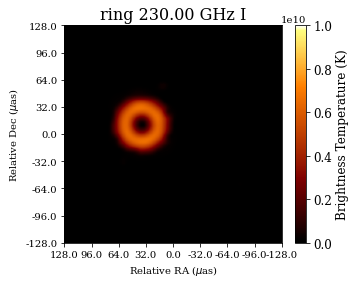

2022-07-27 16:31:11,532 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:31:11,534 INFO Display              :: Penalty--> 195.83446427330526
2022-07-27 16:31:11,741 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:31:11,743 INFO Display              :: Penalty--> 195.83446427330526
2022-07-27 16:31:11,933 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:31:11,935 INFO Display              :: Penalty--> 195.7731766065962
2022-07-27 16:31:12,132 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:31:12,135 INFO Display              :: Penalty--> 195.71188893988713
2022-07-27 16:31:12,334 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:31:12,336 INFO Display              :: Penalty--> 195.68124510653257
2022-07-27 16:31:12,540 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:31:12,541 INFO Display              :: Penalty--> 195.48512515101282
2022-07-27 16:31:12,747 INFO CountIterations      :: iteration = 7 / 25

593.6160820602464
Data Fidelity:  2.032655692368395


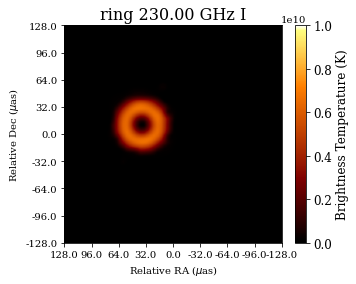

2022-07-27 16:31:16,928 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:31:16,930 INFO Display              :: Penalty--> 192.43966420405937
2022-07-27 16:31:17,149 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:31:17,150 INFO Display              :: Penalty--> 192.40902037070484
2022-07-27 16:31:17,343 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:31:17,345 INFO Display              :: Penalty--> 192.34773270399577
2022-07-27 16:31:17,543 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:31:17,545 INFO Display              :: Penalty--> 192.34773270399577
2022-07-27 16:31:17,744 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:31:17,745 INFO Display              :: Penalty--> 192.34773270399577
2022-07-27 16:31:17,942 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:31:17,944 INFO Display              :: Penalty--> 192.28031627061577
2022-07-27 16:31:18,140 INFO CountIterations      :: iteration = 7 / 2

596.0019157937161
Data Fidelity:  1.6878842674557928


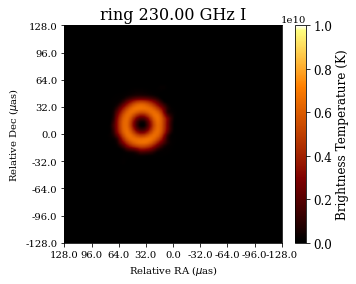

2022-07-27 16:31:22,353 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:31:22,355 INFO Display              :: Penalty--> 191.46940498636994
2022-07-27 16:31:22,562 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:31:22,564 INFO Display              :: Penalty--> 191.46940498636994
2022-07-27 16:31:22,795 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:31:22,797 INFO Display              :: Penalty--> 191.43876115301538
2022-07-27 16:31:22,995 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:31:22,998 INFO Display              :: Penalty--> 191.40811731966085
2022-07-27 16:31:23,200 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:31:23,202 INFO Display              :: Penalty--> 191.2119973641411
2022-07-27 16:31:23,404 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:31:23,406 INFO Display              :: Penalty--> 191.18135353078657
2022-07-27 16:31:23,613 INFO CountIterations      :: iteration = 7 / 25

597.3759169869297
Data Fidelity:  1.461793948873546


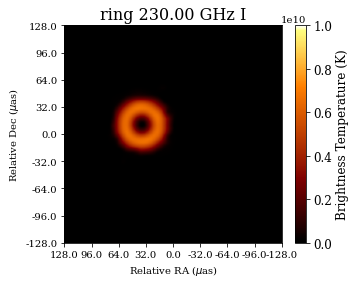

2022-07-27 16:31:27,824 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:31:27,826 INFO Display              :: Penalty--> 190.30494163069469
2022-07-27 16:31:28,027 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:31:28,030 INFO Display              :: Penalty--> 190.29728067235604
2022-07-27 16:31:28,229 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:31:28,231 INFO Display              :: Penalty--> 190.2666368390015
2022-07-27 16:31:28,415 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:31:28,417 INFO Display              :: Penalty--> 190.2666368390015
2022-07-27 16:31:28,621 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:31:28,623 INFO Display              :: Penalty--> 190.10116071683632
2022-07-27 16:31:28,816 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:31:28,818 INFO Display              :: Penalty--> 190.10116071683632
2022-07-27 16:31:29,018 INFO CountIterations      :: iteration = 7 / 25


598.5122881243215
Data Fidelity:  1.3202664806952922


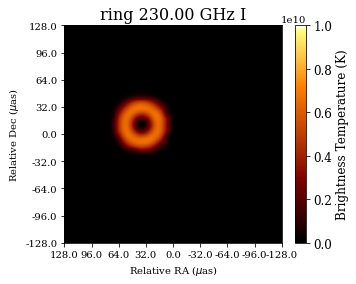

2022-07-27 16:31:33,193 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:31:33,195 INFO Display              :: Penalty--> 188.70892995576585
2022-07-27 16:31:33,404 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:31:33,406 INFO Display              :: Penalty--> 188.6476422890568
2022-07-27 16:31:33,604 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:31:33,606 INFO Display              :: Penalty--> 188.63998133071814
2022-07-27 16:31:33,802 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:31:33,804 INFO Display              :: Penalty--> 188.63998133071814
2022-07-27 16:31:34,005 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:31:34,007 INFO Display              :: Penalty--> 188.60933749736355
2022-07-27 16:31:34,208 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:31:34,209 INFO Display              :: Penalty--> 188.5986121556895
2022-07-27 16:31:34,407 INFO CountIterations      :: iteration = 7 / 25


599.1329823259364
Data Fidelity:  1.2109032066951335


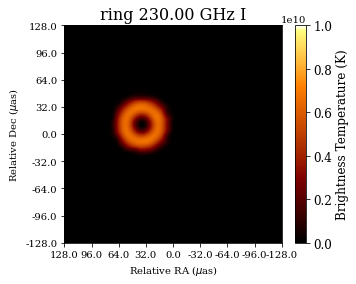

2022-07-27 16:31:38,605 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:31:38,607 INFO Display              :: Penalty--> 187.86929007775012
2022-07-27 16:31:38,800 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:31:38,802 INFO Display              :: Penalty--> 187.86929007775012
2022-07-27 16:31:38,996 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:31:38,998 INFO Display              :: Penalty--> 187.8386462443956
2022-07-27 16:31:39,189 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:31:39,191 INFO Display              :: Penalty--> 187.80800241104106
2022-07-27 16:31:39,380 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:31:39,382 INFO Display              :: Penalty--> 187.80800241104106
2022-07-27 16:31:39,596 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:31:39,598 INFO Display              :: Penalty--> 187.80800241104106
2022-07-27 16:31:39,805 INFO CountIterations      :: iteration = 7 / 25

599.519712657065
Data Fidelity:  1.125698368376479


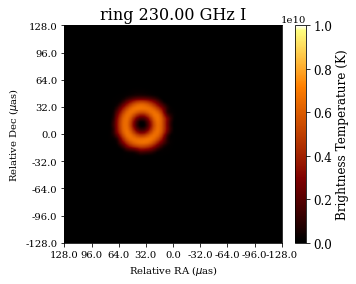

2022-07-27 16:31:43,996 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:31:43,998 INFO Display              :: Penalty--> 186.43415852793254
2022-07-27 16:31:44,219 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:31:44,221 INFO Display              :: Penalty--> 186.43415852793254
2022-07-27 16:31:44,418 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:31:44,419 INFO Display              :: Penalty--> 186.42343318625845
2022-07-27 16:31:44,656 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:31:44,658 INFO Display              :: Penalty--> 186.42343318625845
2022-07-27 16:31:44,901 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:31:44,903 INFO Display              :: Penalty--> 186.42343318625845
2022-07-27 16:31:45,156 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:31:45,159 INFO Display              :: Penalty--> 186.42343318625845
2022-07-27 16:31:45,362 INFO CountIterations      :: iteration = 7 / 2

599.7420882733386
Data Fidelity:  1.0656573621769228


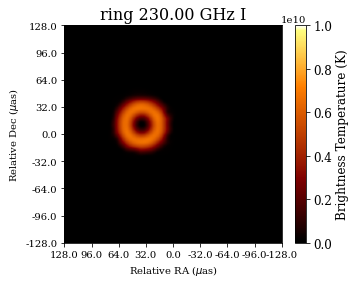

2022-07-27 16:31:49,561 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:31:49,563 INFO Display              :: Penalty--> 185.8277948313282
2022-07-27 16:31:49,764 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:31:49,766 INFO Display              :: Penalty--> 185.8277948313282
2022-07-27 16:31:49,967 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:31:49,968 INFO Display              :: Penalty--> 185.8277948313282
2022-07-27 16:31:50,158 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:31:50,159 INFO Display              :: Penalty--> 185.79715099797366
2022-07-27 16:31:50,358 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:31:50,360 INFO Display              :: Penalty--> 185.79715099797366
2022-07-27 16:31:50,562 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:31:50,564 INFO Display              :: Penalty--> 185.79715099797366
2022-07-27 16:31:50,765 INFO CountIterations      :: iteration = 7 / 25
2

600.1059278997305
Data Fidelity:  1.0245953186284955


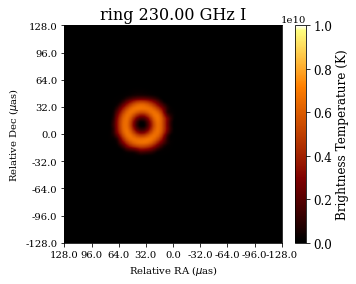

2022-07-27 16:31:54,960 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:31:54,962 INFO Display              :: Penalty--> 185.55200033113738
2022-07-27 16:31:55,160 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:31:55,161 INFO Display              :: Penalty--> 185.55200033113738
2022-07-27 16:31:55,366 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:31:55,368 INFO Display              :: Penalty--> 185.52135649778285
2022-07-27 16:31:55,574 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:31:55,576 INFO Display              :: Penalty--> 185.52135649778285
2022-07-27 16:31:55,760 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:31:55,762 INFO Display              :: Penalty--> 185.49071266442832
2022-07-27 16:31:55,978 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:31:55,980 INFO Display              :: Penalty--> 185.46926198108014
2022-07-27 16:31:56,230 INFO CountIterations      :: iteration = 7 / 2

600.1104187751823
Data Fidelity:  0.992905744639206


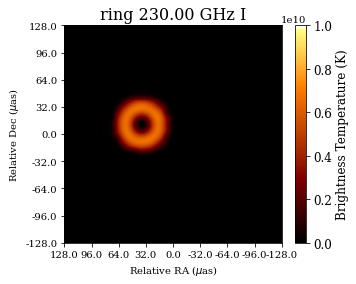

2022-07-27 16:32:00,536 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:32:00,538 INFO Display              :: Penalty--> 185.32063938931066
2022-07-27 16:32:00,765 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:32:00,766 INFO Display              :: Penalty--> 185.2899955559561
2022-07-27 16:32:00,991 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:32:00,993 INFO Display              :: Penalty--> 185.279270214282
2022-07-27 16:32:01,200 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:32:01,202 INFO Display              :: Penalty--> 185.1137940921168
2022-07-27 16:32:01,408 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:32:01,410 INFO Display              :: Penalty--> 185.1137940921168
2022-07-27 16:32:01,638 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:32:01,640 INFO Display              :: Penalty--> 185.1137940921168
2022-07-27 16:32:01,858 INFO CountIterations      :: iteration = 7 / 25
2022

600.2776270526809
Data Fidelity:  0.9631926407821367


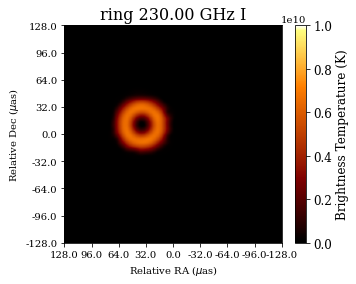

2022-07-27 16:32:06,479 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:32:06,481 INFO Display              :: Penalty--> 184.8870303032425
2022-07-27 16:32:06,681 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:32:06,683 INFO Display              :: Penalty--> 184.8870303032425
2022-07-27 16:32:06,876 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:32:06,877 INFO Display              :: Penalty--> 184.8870303032425
2022-07-27 16:32:07,099 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:32:07,101 INFO Display              :: Penalty--> 184.8870303032425
2022-07-27 16:32:07,340 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:32:07,342 INFO Display              :: Penalty--> 184.8870303032425
2022-07-27 16:32:07,607 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:32:07,610 INFO Display              :: Penalty--> 184.8870303032425
2022-07-27 16:32:07,872 INFO CountIterations      :: iteration = 7 / 25
2022

600.2899997309088
Data Fidelity:  0.941712890055681


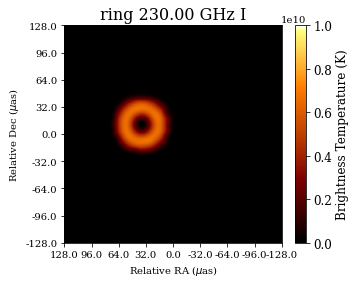

2022-07-27 16:32:13,110 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:32:13,112 INFO Display              :: Penalty--> 184.8349357865398
2022-07-27 16:32:13,357 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:32:13,359 INFO Display              :: Penalty--> 184.8349357865398
2022-07-27 16:32:13,606 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:32:13,608 INFO Display              :: Penalty--> 184.8349357865398
2022-07-27 16:32:13,864 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:32:13,867 INFO Display              :: Penalty--> 184.8349357865398
2022-07-27 16:32:14,112 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:32:14,114 INFO Display              :: Penalty--> 184.8349357865398
2022-07-27 16:32:14,363 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:32:14,366 INFO Display              :: Penalty--> 184.8349357865398
2022-07-27 16:32:14,622 INFO CountIterations      :: iteration = 7 / 25
2022

600.3046385193559
Data Fidelity:  0.9245500637276658


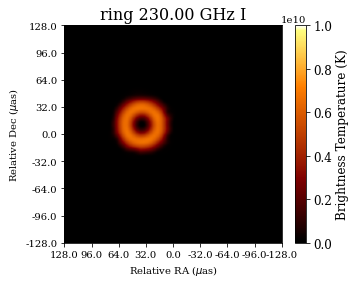

2022-07-27 16:32:19,688 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:32:19,690 INFO Display              :: Penalty--> 184.56986720597237
2022-07-27 16:32:19,938 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:32:19,940 INFO Display              :: Penalty--> 184.53922337261784
2022-07-27 16:32:20,181 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:32:20,183 INFO Display              :: Penalty--> 184.53922337261784
2022-07-27 16:32:20,403 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:32:20,405 INFO Display              :: Penalty--> 184.53922337261784
2022-07-27 16:32:20,645 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:32:20,648 INFO Display              :: Penalty--> 184.53922337261784
2022-07-27 16:32:20,885 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:32:20,887 INFO Display              :: Penalty--> 184.53922337261784
2022-07-27 16:32:21,119 INFO CountIterations      :: iteration = 7 / 2

600.121004423378
Data Fidelity:  0.9034380869777885


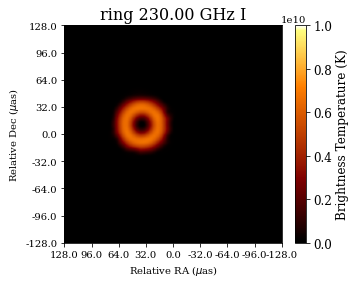

2022-07-27 16:32:26,099 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:32:26,101 INFO Display              :: Penalty--> 184.43350214754466
2022-07-27 16:32:26,298 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:32:26,299 INFO Display              :: Penalty--> 184.43350214754466
2022-07-27 16:32:26,506 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:32:26,508 INFO Display              :: Penalty--> 184.43350214754466
2022-07-27 16:32:26,709 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:32:26,710 INFO Display              :: Penalty--> 184.4227768058706
2022-07-27 16:32:26,910 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:32:26,912 INFO Display              :: Penalty--> 184.39213297251607
2022-07-27 16:32:27,109 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:32:27,112 INFO Display              :: Penalty--> 184.39213297251607
2022-07-27 16:32:27,319 INFO CountIterations      :: iteration = 7 / 25

600.3301550229077
Data Fidelity:  0.8886072211663473


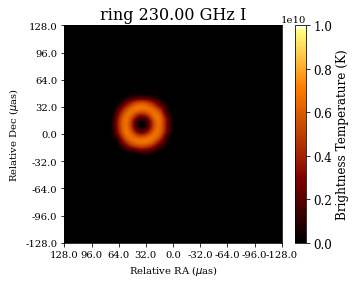

2022-07-27 16:32:31,624 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:32:31,626 INFO Display              :: Penalty--> 184.3124590057943
2022-07-27 16:32:31,808 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:32:31,809 INFO Display              :: Penalty--> 184.3124590057943
2022-07-27 16:32:32,008 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:32:32,010 INFO Display              :: Penalty--> 184.3124590057943
2022-07-27 16:32:32,209 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:32:32,211 INFO Display              :: Penalty--> 184.3124590057943
2022-07-27 16:32:32,397 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:32:32,399 INFO Display              :: Penalty--> 184.3124590057943
2022-07-27 16:32:32,609 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:32:32,611 INFO Display              :: Penalty--> 184.28181517243976
2022-07-27 16:32:32,808 INFO CountIterations      :: iteration = 7 / 25
202

600.3490879487855
Data Fidelity:  0.8751272478399512


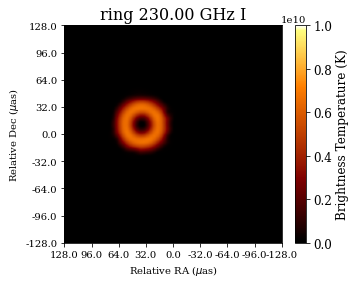

2022-07-27 16:32:37,040 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:32:37,042 INFO Display              :: Penalty--> 183.53501841755136
2022-07-27 16:32:37,249 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:32:37,250 INFO Display              :: Penalty--> 183.50437458419682
2022-07-27 16:32:37,450 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:32:37,452 INFO Display              :: Penalty--> 183.50437458419682
2022-07-27 16:32:37,648 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:32:37,649 INFO Display              :: Penalty--> 182.93492901484777
2022-07-27 16:32:37,853 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:32:37,856 INFO Display              :: Penalty--> 182.93492901484777
2022-07-27 16:32:38,084 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:32:38,086 INFO Display              :: Penalty--> 182.93492901484777
2022-07-27 16:32:38,286 INFO CountIterations      :: iteration = 7 / 2

600.5406977639341
Data Fidelity:  0.862110280390803


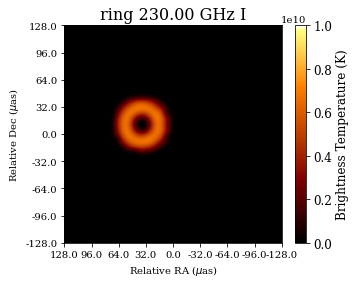

2022-07-27 16:32:42,561 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:32:42,562 INFO Display              :: Penalty--> 182.7296153313724
2022-07-27 16:32:42,759 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:32:42,760 INFO Display              :: Penalty--> 182.7188899896983
2022-07-27 16:32:42,963 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:32:42,965 INFO Display              :: Penalty--> 182.7188899896983
2022-07-27 16:32:43,174 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:32:43,175 INFO Display              :: Penalty--> 182.70816464802422
2022-07-27 16:32:43,377 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:32:43,379 INFO Display              :: Penalty--> 182.70816464802422
2022-07-27 16:32:43,589 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:32:43,591 INFO Display              :: Penalty--> 182.70816464802422
2022-07-27 16:32:43,788 INFO CountIterations      :: iteration = 7 / 25
2

600.3632151397347
Data Fidelity:  0.8500701824585739


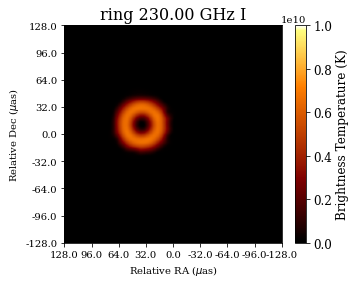

2022-07-27 16:32:48,082 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:32:48,084 INFO Display              :: Penalty--> 182.6150840042098
2022-07-27 16:32:48,277 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:32:48,279 INFO Display              :: Penalty--> 182.6150840042098
2022-07-27 16:32:48,467 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:32:48,469 INFO Display              :: Penalty--> 182.6043586625357
2022-07-27 16:32:48,660 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:32:48,662 INFO Display              :: Penalty--> 182.6043586625357
2022-07-27 16:32:48,853 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:32:48,855 INFO Display              :: Penalty--> 182.6043586625357
2022-07-27 16:32:49,048 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:32:49,050 INFO Display              :: Penalty--> 182.57371482918117
2022-07-27 16:32:49,256 INFO CountIterations      :: iteration = 7 / 25
202

600.1898066635778
Data Fidelity:  0.8379061848568155


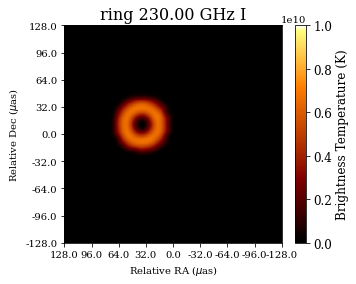

2022-07-27 16:32:53,717 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:32:53,719 INFO Display              :: Penalty--> 182.2952395715211
2022-07-27 16:32:53,920 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:32:53,922 INFO Display              :: Penalty--> 182.2952395715211
2022-07-27 16:32:54,133 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:32:54,136 INFO Display              :: Penalty--> 182.2952395715211
2022-07-27 16:32:54,357 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:32:54,358 INFO Display              :: Penalty--> 182.2952395715211
2022-07-27 16:32:54,578 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:32:54,581 INFO Display              :: Penalty--> 182.2952395715211
2022-07-27 16:32:54,832 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:32:54,834 INFO Display              :: Penalty--> 182.2952395715211
2022-07-27 16:32:55,029 INFO CountIterations      :: iteration = 7 / 25
2022

600.3374736000022
Data Fidelity:  0.829985861090095


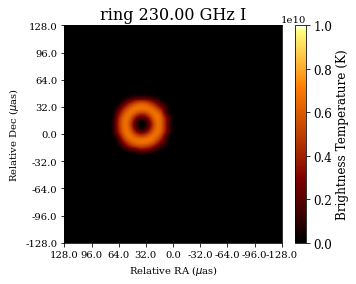

2022-07-27 16:32:59,542 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:32:59,544 INFO Display              :: Penalty--> 182.22322656313796
2022-07-27 16:32:59,762 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:32:59,764 INFO Display              :: Penalty--> 182.21250122146387
2022-07-27 16:32:59,975 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:32:59,977 INFO Display              :: Penalty--> 182.21250122146387
2022-07-27 16:33:00,199 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:33:00,201 INFO Display              :: Penalty--> 182.21250122146387
2022-07-27 16:33:00,428 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:33:00,430 INFO Display              :: Penalty--> 182.21250122146387
2022-07-27 16:33:00,656 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:33:00,658 INFO Display              :: Penalty--> 182.21250122146387
2022-07-27 16:33:00,862 INFO CountIterations      :: iteration = 7 / 2

600.2786954478454
Data Fidelity:  0.8211065230699647


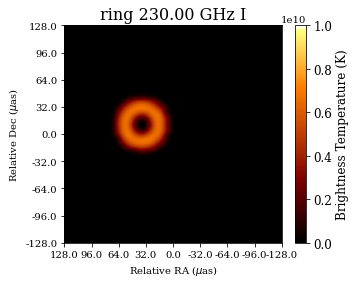

2022-07-27 16:33:05,391 INFO CountIterations      :: iteration = 1 / 25
2022-07-27 16:33:05,393 INFO Display              :: Penalty--> 182.12056972140024
2022-07-27 16:33:05,611 INFO CountIterations      :: iteration = 2 / 25
2022-07-27 16:33:05,613 INFO Display              :: Penalty--> 182.12056972140024
2022-07-27 16:33:05,816 INFO CountIterations      :: iteration = 3 / 25
2022-07-27 16:33:05,818 INFO Display              :: Penalty--> 182.12056972140024
2022-07-27 16:33:06,023 INFO CountIterations      :: iteration = 4 / 25
2022-07-27 16:33:06,025 INFO Display              :: Penalty--> 182.12056972140024
2022-07-27 16:33:06,237 INFO CountIterations      :: iteration = 5 / 25
2022-07-27 16:33:06,239 INFO Display              :: Penalty--> 182.12056972140024
2022-07-27 16:33:06,448 INFO CountIterations      :: iteration = 6 / 25
2022-07-27 16:33:06,450 INFO Display              :: Penalty--> 182.12056972140024
2022-07-27 16:33:06,677 INFO CountIterations      :: iteration = 7 / 2

600.2947441545982
Data Fidelity:  0.8151176649512005


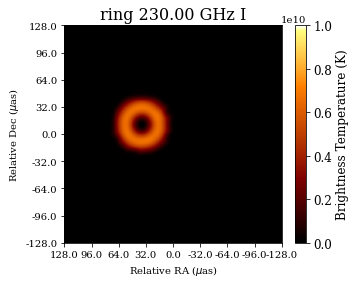

In [8]:
taus = [3, 1]

for i in range(2):
    #blur image to help global convergence
    img = img.blur_circ(psf_fwhm)
    data = handler.convert.ehtim_to_numpy(img)/rescaling
   
    init = np.zeros((len(widths), npix+1, npix+1))
    for j in range(len(widths)):
        init[j] = data
    init = init.flatten()
    
    tau = taus[i]
    
    wtfcts = handler.second_round(init, tau, alpha*noise_levels, maxiter=25, max_iterations=25, display=True)
    
    reco = handler.op(wtfcts)        
    img = handler.wrapper.formatoutput(np.maximum(0, reco))

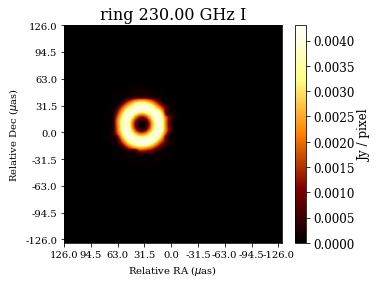

Final data fidelity term:  0.8151176649512005
Final closure phase chi-squared:  0.4027319166753621
Final closure amplitude chi-squared:  0.4123857482758384


In [9]:
img.display()

#print final score
print("Final data fidelity term: ", handler.data_fidelity_closure(wtfcts))
print("Final closure phase chi-squared: ", handler.data_fidelity_cphase(wtfcts))
print("Final closure amplitude chi-squared: ", handler.data_fidelity_logcamp(wtfcts))

Note that although the final data fidelity terms indicate overfitting the final image remains remarkably free from image artifacts due to the powerful regularization. Overfitting can be further reduced by using the discrepancy principle as stopping rule which is fully supported by regpy and imagingbase.